In [ ]:
pip install xgboost lightgbm catboost sklego

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklego.linear_model import LADRegression

In [109]:
train = pd.read_csv('train.csv').drop(columns = ['id'])
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
original = pd.read_csv('original.csv')

In [110]:
train['generated'] = 1
original['generated'] = 0
test['generated'] = 1

train = pd.concat([train, original], axis = 0).reset_index(drop = True)

## Exploratory Data Analysis:

In [111]:
train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,generated
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,1
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,1
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,1
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,1


In [112]:
train.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,generated
count,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000
mean,1.317153,1.024316,0.348154,23.394310,10.109418,5.062290,6.727465,9.967156,0.950054
std,0.288404,0.237949,0.092723,12.713088,5.652666,2.809131,3.603159,3.177472,0.217835
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000,0.000000
25%,1.150000,0.887500,0.287500,13.395139,5.712424,2.849125,3.940580,8.000000,1.000000
50%,1.375000,1.075000,0.362500,23.728531,9.879801,4.975337,6.874754,10.000000,1.000000
75%,1.537500,1.200000,0.412500,32.162508,14.047177,7.002326,9.086015,11.000000,1.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000,1.000000


In [113]:
print(train.shape)
print(test.shape)

(77944, 10)
(49368, 10)


In [114]:
print(train.isna().sum())
print('\n', test.isna().sum())

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
generated         0
dtype: int64

 id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
generated         0
dtype: int64


In [115]:
train.drop(columns = ['Sex']).corr()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,generated
Length,1.000000,0.989285,0.912514,0.935655,0.914366,0.916863,0.915757,0.609776,0.004649
Diameter,0.989285,1.000000,0.915725,0.937458,0.912876,0.917149,0.921620,0.618737,0.003298
Height,0.912514,0.915725,1.000000,0.896341,0.858228,0.877494,0.897728,0.632889,-0.003017
Weight,0.935655,0.937458,0.896341,1.000000,0.971127,0.970724,0.964912,0.597640,-0.003120
Shucked Weight,0.914366,0.912876,0.858228,0.971127,1.000000,0.941930,0.908695,0.498437,-0.003972
Viscera Weight,0.916863,0.917149,0.877494,0.970724,0.941930,1.000000,0.932237,0.572442,-0.006061
Shell Weight,0.915757,0.921620,0.897728,0.964912,0.908695,0.932237,1.000000,0.661228,-0.004351
Age,0.609776,0.618737,0.632889,0.597640,0.498437,0.572442,0.661228,1.000000,0.000892
generated,0.004649,0.003298,-0.003017,-0.003120,-0.003972,-0.006061,-0.004351,0.000892,1.000000


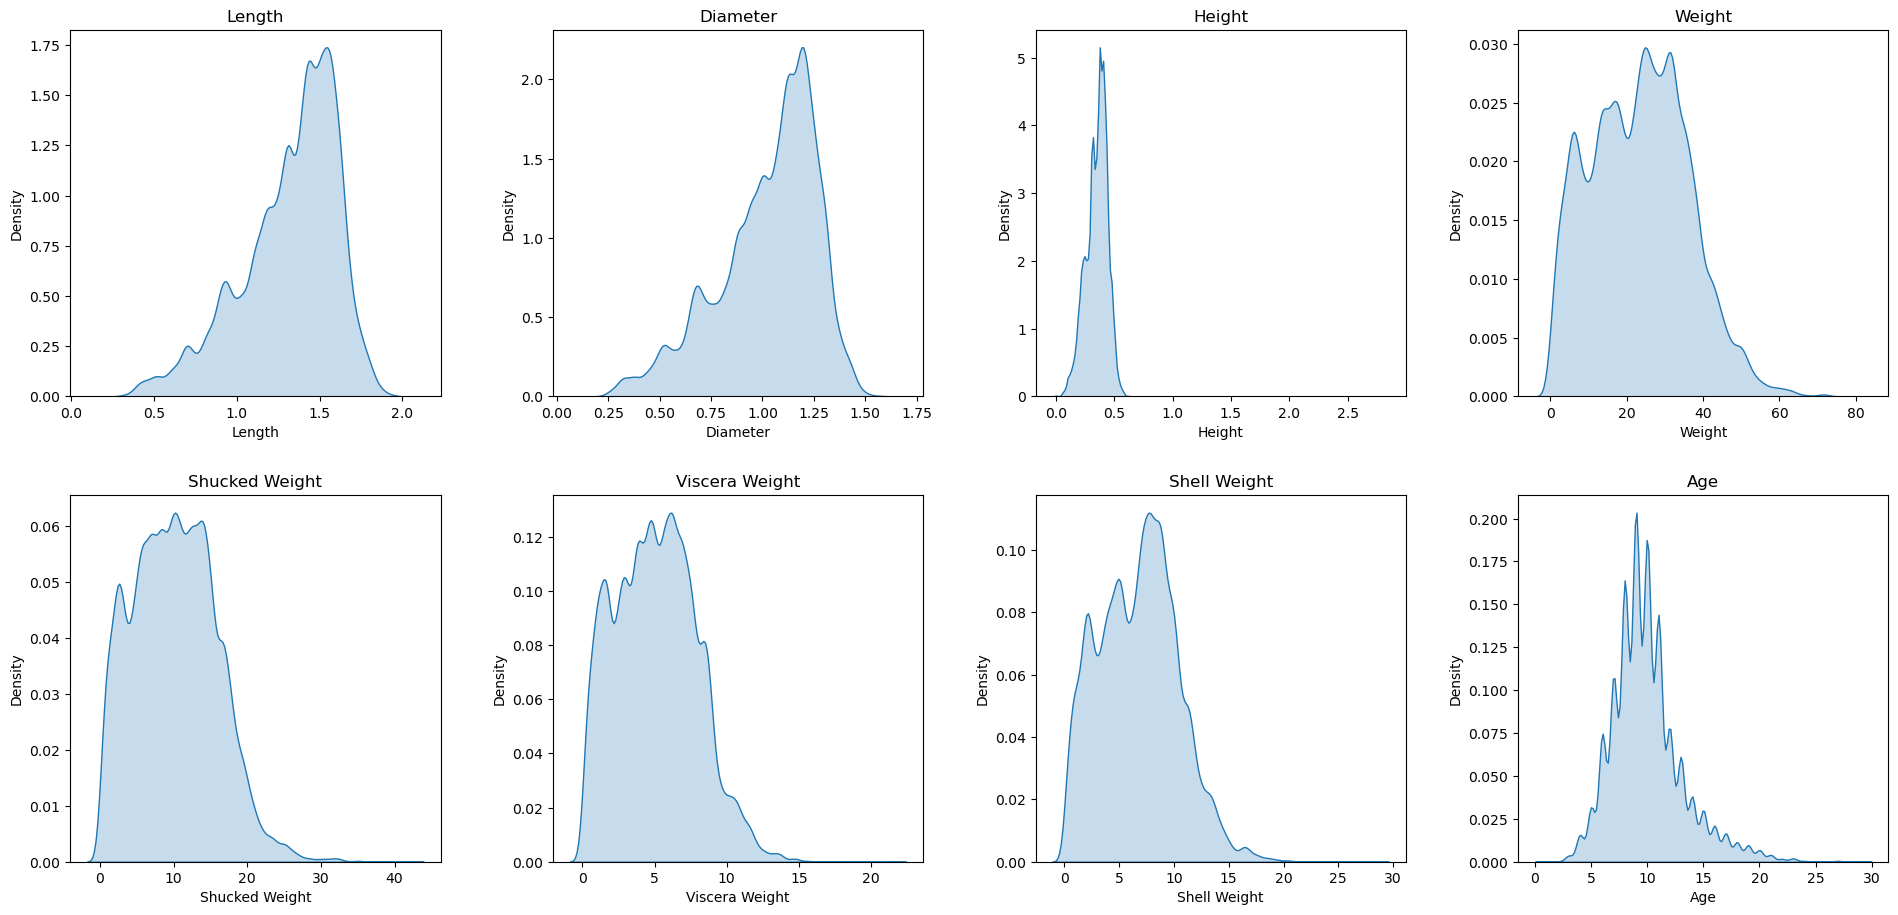

In [116]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))
plt.tight_layout(pad = 5)

sns.kdeplot(ax = axes[0, 0], data = train, x = 'Length', fill = True).set_title('Length')
sns.kdeplot(ax = axes[0, 1], data = train, x = 'Diameter', fill = True).set_title('Diameter')
sns.kdeplot(ax = axes[0, 2], data = train, x = 'Height', fill = True).set_title('Height')
sns.kdeplot(ax = axes[0, 3], data = train, x = 'Weight', fill = True).set_title('Weight')
sns.kdeplot(ax = axes[1, 0], data = train, x = 'Shucked Weight', fill = True).set_title('Shucked Weight')
sns.kdeplot(ax = axes[1, 1], data = train, x = 'Viscera Weight', fill = True).set_title('Viscera Weight')
sns.kdeplot(ax = axes[1, 2], data = train, x = 'Shell Weight', fill = True).set_title('Shell Weight')
sns.kdeplot(ax = axes[1, 3], data = train, x = 'Age', fill = True).set_title('Age')
plt.show()

## Feature Engineering:

In [117]:
train['Male'] = np.where(train['Sex'] == 'M', 1, 0); train['Female'] = np.where(train['Sex'] == 'F', 1, 0)
test['Male'] = np.where(test['Sex'] == 'M', 1, 0); test['Female'] = np.where(test['Sex'] == 'F', 1, 0)

In [118]:
train['Shucked Weight Perc.'] = train['Shucked Weight'] / train['Weight']
train['Viscera Weight Perc.'] = train['Viscera Weight'] / train['Weight']
train['Shell Weight Perc.'] = train['Shell Weight'] / train['Weight']

test['Shucked Weight Perc.'] = test['Shucked Weight'] / test['Weight']
test['Viscera Weight Perc.'] = test['Viscera Weight'] / test['Weight']
test['Shell Weight Perc.'] = test['Shell Weight'] / test['Weight']

In [ ]:
# grouped = train.groupby('Sex')['Shucked Weight'].agg([np.min, np.max, np.median, np.mean]).reset_index()
# grouped.columns = ['Sex','min_price_by_pos', 'max_price_by_pos','median_price_by_pos','mean_price_by_pos']

# ## Adding aggregated price info
# full_data = pd.merge(full_data, price_by_pos, how = 'left', on = 'pos')

In [120]:
train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,generated,Male,Female,Shucked Weight Perc.,Viscera Weight Perc.,Shell Weight Perc.
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,1,0,0,0.439335,0.229452,0.288160
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,1,0,0,0.434014,0.223129,0.326531
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,1,1,0,0.457666,0.224256,0.268879
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1,0,1,0.401791,0.216970,0.296027
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,1,0,0,0.514303,0.193548,0.255630


## Hyper-parameter Tuning:

## Modelling:

In [121]:
## Dropping some variables
train.drop(columns = ['Sex'], axis = 1, inplace = True)
test.drop(columns = ['id', 'Sex'], axis = 1, inplace = True)

## Defining the input and target variables
X = train.drop(columns = ['Age'], axis = 1)
Y = train['Age']

## Defining lists to store results
gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

## Performing KFold cross-validation
skf = KFold(n_splits = 10, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ######################
    ## GradientBoosting ##
    ######################
        
    gb_md = GradientBoostingRegressor(loss = 'absolute_error', n_estimators = 1000, max_depth = 8, learning_rate = 0.01,
                                      min_samples_split = 10, min_samples_leaf = 20).fit(X_train, Y_train) 
    
    gb_pred_1 = gb_md.predict(X_test[X_test['generated'] == 1])
    gb_pred_2 = gb_md.predict(test)
    
    gb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)
    
    print('Fold', i, '==> GradientBoositng oof MAE is ==>', gb_score_fold)
    
    
    ##########################
    ## HistGradientBoosting ##
    ##########################
        
    hist_md = HistGradientBoostingRegressor(loss = 'absolute_error', l2_regularization = 0.01, early_stopping = False, learning_rate = 0.01,
                                            max_iter = 1000, max_depth = 15, max_bins = 255, min_samples_leaf = 30, 
                                            max_leaf_nodes = 30).fit(X_train, Y_train)
    
    hist_pred_1 = hist_md.predict(X_test[X_test['generated'] == 1])
    hist_pred_2 = hist_md.predict(test)

    hist_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], hist_pred_1)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)
    
    print('Fold', i, '==> HistGradient oof MAE is ==>', hist_score_fold)
        
    ##############
    ## LightGBM ##
    ##############
        
    lgb_md = LGBMRegressor(objective = 'mae', n_estimators = 1000, max_depth = 10, learning_rate = 0.01, num_leaves = 70, reg_alpha = 3,
                           reg_lambda = 3, subsample = 0.7, colsample_bytree = 0.7).fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict(X_test[X_test['generated'] == 1])
    lgb_pred_2 = lgb_md.predict(test)

    lgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], lgb_pred_1)    
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i, '==> LightGBM oof MAE is ==>', lgb_score_fold)
        
    #############
    ## XGBoost ##
    #############
        
    xgb_md = XGBRegressor(objective = 'reg:pseudohubererror', colsample_bytree = 0.7, gamma = 0.8, learning_rate = 0.01, max_depth = 8, 
                          min_child_weight = 20, n_estimators = 1000, subsample = 0.7).fit(X_train, Y_train)
    
    xgb_pred_1 = xgb_md.predict(X_test[X_test['generated'] == 1])
    xgb_pred_2 = xgb_md.predict(test)

    xgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], xgb_pred_1)    
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)
    
    print('Fold', i, '==> XGBoost oof MAE is ==>', xgb_score_fold)
    
    ##################
    ## LAD Ensemble ##
    ##################
    
    x = pd.DataFrame({'GBC':gb_pred_1,  'hist': hist_pred_1, 'lgb': lgb_pred_1, 'xgb': xgb_pred_1})
    y = Y_test[X_test['generated'] == 1]
    
    lad_md = LADRegression().fit(x, y)
    lad_pred = lad_md.predict(x)
    
    x_test = pd.DataFrame({'GBC':gb_pred_2,  'hist': hist_pred_2, 'lgb': lgb_pred_2, 'xgb': xgb_pred_2})
    lad_pred_test = lad_md.predict(x_test)
        
    ens_score = mean_absolute_error(y, lad_pred)
    ens_cv_scores.append(ens_score)
    ens_preds.append(lad_pred_test)
    
    print('Fold', i, '==> LAD ensemble oof MAE is ==>', ens_score)

---------------------------------------------------------------
Fold 0 ==> GradientBoositng oof MAE is ==> 1.3626961928568226
Fold 0 ==> HistGradient oof MAE is ==> 1.3731995537868946
Fold 0 ==> LightGBM oof MAE is ==> 1.3578369861475008
Fold 0 ==> XGBoost oof MAE is ==> 1.3684900423926765
Fold 0 ==> LAD ensemble oof MAE is ==> 1.3572869345154743
---------------------------------------------------------------
Fold 1 ==> GradientBoositng oof MAE is ==> 1.3618076350526354
Fold 1 ==> HistGradient oof MAE is ==> 1.3719754137134321
Fold 1 ==> LightGBM oof MAE is ==> 1.3568920667989723
Fold 1 ==> XGBoost oof MAE is ==> 1.3637905055014738
Fold 1 ==> LAD ensemble oof MAE is ==> 1.3555466280926984
---------------------------------------------------------------
Fold 2 ==> GradientBoositng oof MAE is ==> 1.3682376821390185
Fold 2 ==> HistGradient oof MAE is ==> 1.3787439936894537
Fold 2 ==> LightGBM oof MAE is ==> 1.3641523659498105
Fold 2 ==> XGBoost oof MAE is ==> 1.3702884785808924
Fold 2 ==> 

In [122]:
print(np.mean(gb_cv_scores))
print(np.mean(hist_cv_scores))
print(np.mean(lgb_cv_scores))
print(np.mean(xgb_cv_scores))
print(np.mean(ens_cv_scores))

1.3587006251623799
1.3676792385295615
1.3530778289498537
1.3640297074504832
1.3519540332296613


In [123]:
gb_preds_test = pd.DataFrame(gb_preds).apply(np.mean, axis = 0)
hist_preds_test = pd.DataFrame(hist_preds).apply(np.mean, axis = 0)
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
xgb_preds_test = pd.DataFrame(xgb_preds).apply(np.mean, axis = 0)
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)

sub['Age'] = gb_preds_test
sub.to_csv('submissions/GB_submission.csv', index = False)

sub['Age'] = hist_preds_test
sub.to_csv('submissions/Hist_submission.csv', index = False)

sub['Age'] = lgb_preds_test
sub.to_csv('submissions/LightGBM_submission.csv', index = False)

sub['Age'] = xgb_preds_test
sub.to_csv('submissions/XGBoost_submission.csv', index = False)

sub['Age'] = ens_preds_test
sub.to_csv('submissions/Ensemble_submission.csv', index = False)